# Milk Production Forecasting: A Time-Series Analysis


This notebook walks through the process of forecasting daily milk production using a time-series dataset. The goal is to build a model that can predict future production based on historical patterns. The workflow is broken down into four key stages: data loading, feature engineering, model training, and evaluation.

In [2]:
# !pip install -U pandas scikit-learn xgboost matplotlib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## 1. Data Collection & Loading

First, we load the historical milk production data from a CSV file into a pandas DataFrame. The initial steps involve:

Loading the Data: Reading the raw CSV file.

Data Cleaning: Ensuring the primary data column (Milk_ML) is a numeric type, converting any non-numeric placeholders like ' - ' into NaN (Not a Number) to represent missing values.

Datetime Conversion: Converting the Date column into a proper datetime format, which is essential for time-series analysis.

Setting the Index: Setting the Date column as the DataFrame's index to allow for easy time-based slicing and analysis.

In [4]:
# Load the data
df = pd.read_csv("./milk_daily_UK_million_litres.csv")

df.columns = ['Date', 'Milk_ML']

# Convert 'Date' column to a proper datetime object
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Set the 'Date' as the index of the DataFrame. This is crucial for time-series analysis.
df = df.set_index('Date')

df['Milk_ML'] = pd.to_numeric(df['Milk_ML'], errors='coerce')

# Display the first few rows to check
print("\nData loaded and prepared:")
df.head()


Data loaded and prepared:


,Milk_ML
Date,
2008-04-01,36.77
2008-04-02,37.25
2008-04-03,37.21
2008-04-04,37.61
2008-04-05,37.45


In [5]:
# Check what pandas considers to be a "column"
print('COLUMNS:', df.columns)

# Check the name of your new index
print('INDEX NAME:', df.index.name)

COLUMNS: Index(['Milk_ML'], dtype='object')
INDEX NAME: Date


## 2. Data Preprocessing & Feature Engineering

With the data loaded, the next step is to create new features from the existing data. Since we only have the production values and timestamps, we'll engineer features that help the model understand time-based patterns. This process, known as feature engineering, is crucial for the model's performance.

We create three types of features:

Time-Based Features: Extracting information like the year, month, and day of the week from the date. This helps the model identify yearly and weekly seasonal patterns.

Lag Features: Creating features that represent the milk production from previous days (e.g., 1 day ago, 7 days ago). This is highly predictive, as today's production is often related to yesterday's.

Rolling Window Features: Calculating statistics like the rolling average over a specific window (e.g., the last 7 days). This smooths out short-term fluctuations and helps the model capture the recent trend.

In [6]:
# Feature Engineering

def create_time_series_features(df):
    """
    Creates time-series features from a datetime index.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_featured = df.copy()
    
    # Time-based Features
    df_featured['year'] = df_featured.index.year
    df_featured['month'] = df_featured.index.month
    df_featured['dayofweek'] = df_featured.index.dayofweek # Monday=0, Sunday=6
    df_featured['dayofyear'] = df_featured.index.dayofyear
    df_featured['weekofyear'] = df_featured.index.isocalendar().week.astype(int)
    
    # Lag Features (milk production from previous time points)
    # We use a 1-day lag and a 1-week lag as examples
    df_featured['lag_1'] = df_featured['Milk_ML'].shift(1)
    df_featured['lag_7'] = df_featured['Milk_ML'].shift(7)
    
    # Rolling Window Features
    # We calculate the average production over the last 7 days
    df_featured['rolling_mean_7'] = df_featured['Milk_ML'].shift(1).rolling(window=7).mean()
    
    # Remove rows with missing values that were created by lags/rolling windows
    df_featured = df_featured.dropna()
    
    return df_featured

df_featured = create_time_series_features(df)

print("\nDataFrame with new features:")
print(df_featured.head())


DataFrame with new features:
            Milk_ML  year  month  dayofweek  dayofyear  weekofyear  lag_1  \
Date                                                                        
2008-04-08    37.31  2008      4          1         99          15  37.23   
2008-04-09    37.48  2008      4          2        100          15  37.31   
2008-04-10    37.41  2008      4          3        101          15  37.48   
2008-04-11    37.69  2008      4          4        102          15  37.41   
2008-04-12    37.89  2008      4          5        103          15  37.69   

            lag_7  rolling_mean_7  
Date                               
2008-04-08  36.77       37.320000  
2008-04-09  37.25       37.397143  
2008-04-10  37.21       37.430000  
2008-04-11  37.61       37.458571  
2008-04-12  37.45       37.470000  


## 3. Model Training

Now we train a machine learning model to learn the patterns from our engineered features. For this task, we use XGBoost (Extreme Gradient Boosting), a powerful and popular algorithm for tabular data.

The process is as follows:

Data Splitting: We split the dataset into a training set and a testing set. It's critical for time-series data to not shuffle the data. We train the model on older data (e.g., 2008-2022) and hold out the more recent data (e.g., 2023 onwards) to test its performance on unseen future data.

Model Initialization: We define the XGBoost regressor model with specific parameters.

Training: We fit the model on the training data (X_train and y_train). The model learns the relationships between the features we created (like lag_7, month, etc.) and the target variable (Milk_ML).

In [7]:
# Block 3: Data Splitting and Model Training

# Define a cutoff date for our training/testing split
split_date = '2023-01-01'

# Split the data
train_set = df_featured.loc[df_featured.index < split_date]
test_set = df_featured.loc[df_featured.index >= split_date]

# Define which columns are features and which one is the target
FEATURES = ['year', 'month', 'dayofweek', 'dayofyear', 'weekofyear', 'lag_1', 'lag_7', 'rolling_mean_7']
TARGET = 'Milk_ML'

X_train = train_set[FEATURES]
y_train = train_set[TARGET]

X_test = test_set[FEATURES]
y_test = test_set[TARGET]

# Initialize and train the XGBoost Regressor model
# n_estimators = number of boosting rounds (trees)
# learning_rate = how much to shrink the contribution of each tree
# early_stopping_rounds = stops training if validation score doesn't improve
print("\nTraining the XGBoost model...")
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    enable_categorical=False, 
    early_stopping_rounds=10 # Stop if performance on eval set doesn't improve for 10 rounds
)

# We use the test set as the evaluation set to monitor for overfitting
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False) # Set verbose=True to see training progress

print("Model training complete.")


Training the XGBoost model...
Model training complete.


## 4. Model Evaluation & Visualization

The final step is to evaluate how well our trained model performs. We use the model to make predictions on the test set (the data it has never seen before) and compare these predictions to the actual milk production values.

Prediction: The trained model predicts the milk production for the test period.

Visualization: We plot the actual production values against the model's predictions. This visual check is the best way to assess the model's accuracy and see if it successfully captured the trend and seasonality of the data.

Error Metric: We can also calculate a metric like Root Mean Squared Error (RMSE) to get a quantitative measure of the model's average prediction error.

C:\Users\Snobin\AppData\Local\Temp\ipykernel_26860\2253804823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['prediction'] = reg.predict(X_test)



Root Mean Squared Error (RMSE) on Test Set: 0.54 Liters
This means the model's predictions are, on average, off by about this many liters.


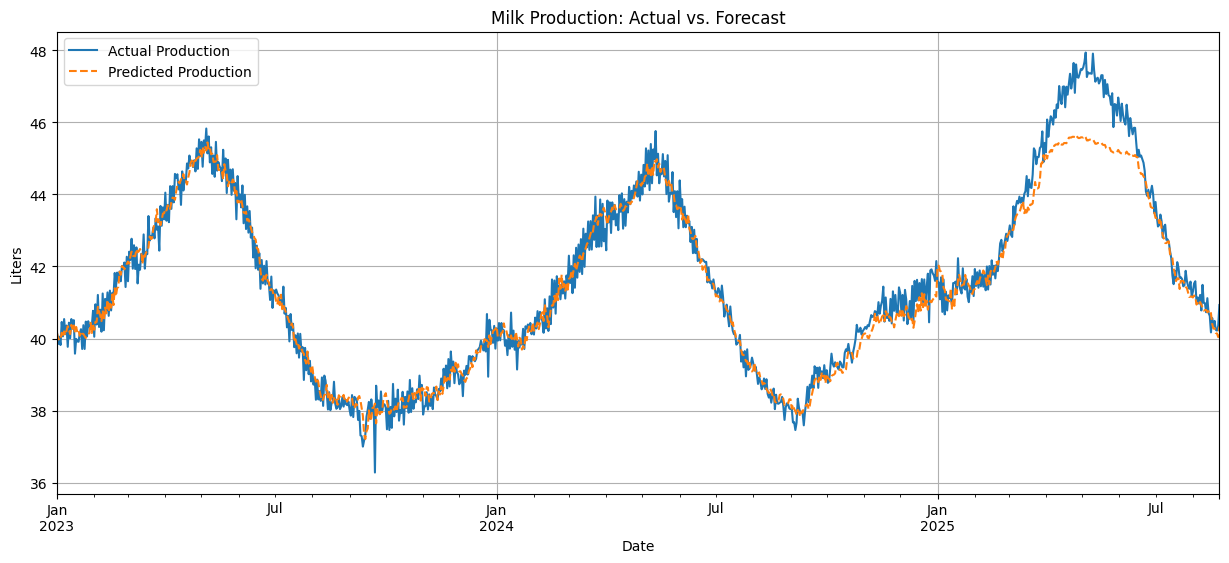


Test set with predictions:
            Milk_ML  prediction
Date                           
2023-01-01    40.19   40.156094
2023-01-02    39.85   40.012882
2023-01-03    40.05   39.951538
2023-01-04    39.82   39.977417
2023-01-05    40.46   40.160938


In [8]:
# Block 4: Making Predictions and Evaluating

# Use the trained model to predict the test set
test_set['prediction'] = reg.predict(X_test)

# Calculate the error
rmse = np.sqrt(mean_squared_error(test_set['Milk_ML'], test_set['prediction']))
print(f"\nRoot Mean Squared Error (RMSE) on Test Set: {rmse:.2f} Liters")
print("This means the model's predictions are, on average, off by about this many liters.")

# Plot the results
fig, ax = plt.subplots(figsize=(15, 6))

test_set['Milk_ML'].plot(ax=ax, label='Actual Production', style='-')
test_set['prediction'].plot(ax=ax, label='Predicted Production', style='--')

ax.set_title('Milk Production: Actual vs. Forecast')
ax.set_ylabel('Liters')
ax.set_xlabel('Date')
ax.legend()
plt.grid(True)
plt.show()

# Display the first few rows with predictions
print("\nTest set with predictions:")
print(test_set[['Milk_ML', 'prediction']].head())